In [1]:
#Appropriated/Inspired from https://github.com/hunkim/PyTorchZeroToAll/blob/master/13_1_rnn_classification_basics.py

import pandas as pd 
import numpy as np
import pygsheets
import os
import logging
import torch
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

#note: training data removed due to company policy.


In [59]:
df_train.iloc[120:130]

,Database,make_model,token_size
120,bmw 2 series coupe/conv,"('bmw', '2-series')",4
121,bmw 2-series coupe/conv,"('bmw', '2-series')",3
122,bmw 3,"('bmw', '3-series')",2
123,bmw 3 series,"('bmw', '3-series')",3
124,bmw 3 series coupe/conv,"('bmw', '3-series')",4
125,bmw 3 series gran turismo,"('bmw', '3-series')",5
126,bmw 330 gt,"('bmw', '3-series')",3
127,bmw 4,"('bmw', '4-series')",2
128,bmw 4 series coupe/conv,"('bmw', '4-series')",4
129,bmw 4 series gran coupe,"('bmw', '4-series')",5


In [4]:
### Creating your own torch dataset
#https://github.com/hunkim/PyTorchZeroToAll/blob/master/13_2_rnn_classification.py
##https://blog.godatadriven.com/fairness-in-pytorch

class NameDataset(Dataset):


    # Initialize your data, download, etc.
    def __init__(self,df, is_train_set=False):
        

        self.text_input = list(df['Database'])
        self.make_model = list(df['make_model'])
        self.len = len(self.make_model)

        self.make_model_list = list(sorted(set(self.make_model)))

    def __getitem__(self, index):
        return self.text_input[index], self.make_model[index]

    def __len__(self):
        return self.len

    def get_make_models(self):
        return self.make_model_list

    def get_make_model(self, id):
        return self.make_model_list[id]

    def get_make_model_id(self, make_model):
        return self.make_model_list.index(make_model)

In [5]:
BATCH_SIZE=256

# Using PyTorch's DataLoader
train_dataset = NameDataset(df_train,is_train_set=True)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE, shuffle=True)

test_dataset = NameDataset(df_train,is_train_set=False)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE, shuffle=True)

data=NameDataset(df_train)

In [7]:
train_loader.dataset.make_model_list[:4]

["('', '')", "('acura', 'cdx')", "('acura', 'mdx')", "('acura', 'rdx')"]

In [8]:
train_loader.dataset.get_make_model(3)

"('acura', 'rdx')"

In [9]:
### converting characters to numercals

def str2ascii_arr(msg):
    arr = [ord(c) for c in msg]
    return arr, len(arr)


In [10]:
print(str2ascii_arr(u'volkswagen amarok'))

([118, 111, 108, 107, 115, 119, 97, 103, 101, 110, 32, 97, 109, 97, 114, 111, 107], 17)


In [11]:
### Getting the Make Model index IDs when search on make models

def models2tensor(models,dataset):
    model_ids = [dataset.get_make_model_id(
        model) for model in models]
    return torch.LongTensor(model_ids)

In [12]:
model_sample=data.make_model_list[:5]
model_ids=models2tensor(model_sample,train_dataset)
print("Sample of the Models in the train dataset: {a}".format(a=model_sample))
print(model_ids)

Sample of the Models in the train dataset: ["('', '')", "('acura', 'cdx')", "('acura', 'mdx')", "('acura', 'rdx')", "('acura', 'tlx')"]
tensor([0, 1, 2, 3, 4])


In [13]:
###Padding and making variables

def create_variable(tensor):
    # Do cuda() before wrapping with variable
    if torch.cuda.is_available():
        return Variable(tensor.cuda())
    else:
        return Variable(tensor)


def pad_sequences(vectorized_seqs, seq_lengths, models):
    seq_tensor = torch.zeros((len(vectorized_seqs), seq_lengths.max())).long()
    for idx, (seq, seq_len) in enumerate(zip(vectorized_seqs, seq_lengths)):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)

    # Sort tensors by their length
    seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
    seq_tensor = seq_tensor[perm_idx]

    # Also sort the target (countries) in the same order
    target = models2tensor(models, train_dataset)
    if len(models):
        target = target[perm_idx]

    # Return variables
    # DataParallel requires everything to be a Variable
    return create_variable(seq_tensor), \
        create_variable(seq_lengths), \
        create_variable(target)

def make_variables(names, countries):
    sequence_and_length = [str2ascii_arr(name) for name in names]
    vectorized_seqs = [sl[0] for sl in sequence_and_length]
    seq_lengths = torch.LongTensor([sl[1] for sl in sequence_and_length])
    return pad_sequences(vectorized_seqs, seq_lengths, countries)



In [14]:
for i, (text, models) in enumerate(train_loader, 1):
        input, seq_lengths, target= make_variables(text, models)
        

In [45]:
### This is an example 

for i, (text, models) in enumerate(test_loader, 1):
    if i ==1:
        print(i)
        text_x=text[0], 
        model_x=models[0]
        print(len(models))
        print('text_input: ',text_x)
        print('make and model ', model_x)
        print('tensored example',str2ascii_arr(text[0])[0])
        print('')
        print('example of padded input: ',input[-1])
        input_x, seq_lengths_x, target_x = make_variables([(text_x)[0]], [])
        print(input_x, seq_lengths_x)
        
        

1
256
text_input:  ('ferrari fxx-k',)
make and model  ('ferrari', 'fxx-k')
tensored example [102, 101, 114, 114, 97, 114, 105, 32, 102, 120, 120, 45, 107]

example of padded input:  tensor([100, 115,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0])
tensor([[102, 101, 114, 114,  97, 114, 105,  32, 102, 120, 120,  45, 107]]) tensor([13])


In [46]:
for i, (text, models) in enumerate(train_loader, 1):
    if i ==1:
        print(i)
        print(text[0])
        print(models[0])
        print('tensored example',str2ascii_arr(text[0])[0])
        input_x, seq_lengths_x, target_x = make_variables([(text)[0]], (models))
        print(input_x, target_x)

1
bugatti veyron
('bugatti', 'veyron')
tensored example [98, 117, 103, 97, 116, 116, 105, 32, 118, 101, 121, 114, 111, 110]
tensor([[ 98, 117, 103,  97, 116, 116, 105,  32, 118, 101, 121, 114, 111, 110]]) tensor([121])


In [47]:
class RNNClassifier(nn.Module):
    # Our model

    def __init__(self, input_size, hidden_size, output_size, n_layers=1, bidirectional=True):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_directions = int(bidirectional) + 1

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, seq_lengths):
        # Note: we run this all at once (over the whole input sequence)
        # input shape: B x S (input size)
        # transpose to make S(sequence) x B (batch)
        input = input.t()
        batch_size = input.size(1)

        # Make a hidden
        hidden = self._init_hidden(batch_size)

        # Embedding S x B -> S x B x I (embedding size)
        embedded = self.embedding(input)

        # Pack them up nicely
        gru_input = pack_padded_sequence(
            embedded, seq_lengths.data.cpu().numpy())
        
        ''' pack_padded_sequence package
        They are used for seq to seq models with variable lengths. 
        Such as a sentence can be of variable length, 
        and to feed it into any class of an RNN, you need to be able to get the output at the 
        right time step.
        '''
        # To compact weights again call flatten_parameters().
        self.gru.flatten_parameters()
        output, hidden = self.gru(gru_input, hidden)

        # Use the last layer output as FC's input
        # No need to unpack, since we are going to use hidden
        fc_output = self.fc(hidden[-1])
        return fc_output

    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers * self.n_directions,
                             batch_size, self.hidden_size)
        
        ## note: the initial hidden size is determined by the batch og the data and the 
        ## architechture of the model
        return hidden




In [64]:
import matplotlib.pyplot as plt
import time
import math


def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

HIDDEN_SIZE=256
N_LAYERS=3
N_MODELS=len(data.make_model_list)
N_CHARS = 128  # ASCII


num_epochs=40
total_loss = 0
iter = 0
learning_rate=1e-3

model = RNNClassifier(N_CHARS, HIDDEN_SIZE, N_MODELS, N_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
criterion = nn.CrossEntropyLoss()


 37s] Train Epoch: 7 [256/1645 (16%)] loss:3.38, total_loss: 0.97 iter:50

Test set: Accuracy: 498/1645 (30%)

 18s] Train Epoch: 14 [256/1645 (16%)] loss:1.81, total_loss: 1.46 iter:100

Test set: Accuracy: 1057/1645 (64%)

 3s] Train Epoch: 21 [256/1645 (16%)] loss:0.86, total_loss: 1.70 iter:150

Test set: Accuracy: 1459/1645 (88%)

 47s] Train Epoch: 28 [256/1645 (16%)] loss:0.46, total_loss: 1.82 iter:200

Test set: Accuracy: 1601/1645 (97%)

 34s] Train Epoch: 35 [256/1645 (16%)] loss:0.22, total_loss: 1.88 iter:250

Test set: Accuracy: 1632/1645 (99%)



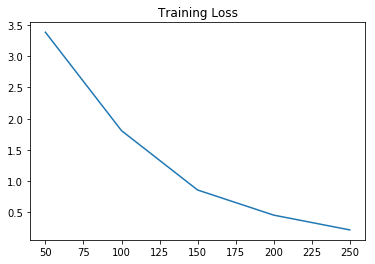

In [65]:
iter_n=[]
loss_n=[]
for epoch in range(num_epochs):
    for i, (names, countries) in enumerate(train_loader):
        input, seq_lengths, target = make_variables(names, countries)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        #make the class
        output = model(input, seq_lengths)
        
        #calculate loss
        loss = criterion(output, target)
        total_loss += loss.item()

        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        
        
        iter += 1
        
        if iter % 50 == 0:
            print('[{}] Train Epoch: {} [{}/{} ({:.0f}%)] loss:{:.2f}, total_loss: {:.2f} iter:{}'.format(
                time_since(start), 
                epoch,  
                len(names), 
                len(train_loader.dataset),
                (len(names) / len(train_loader.dataset))*100,
                loss,
                total_loss / len(names), 
                iter)
                 )
            
            correct = 0
            total = 0
            
            iter_n.append(iter)
            loss_n.append(loss)
            
            for i, (names, countries) in enumerate(test_loader):
                input, seq_lengths, target = make_variables(names, countries)
                output = model(input, seq_lengths)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()
                total += len(countries)
            
            print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
            correct, total, 100. * correct / total))
            
            
            #loss_n.append(total_loss)
            i#ter_n.append(iter)
            
            
import matplotlib.pyplot as plt
plt.title('Training Loss')
plt.plot(iter_n,loss_n, '-')
plt.show()

In [63]:
def test(name=None):
    # Predict for a given name
    if name:
        input, seq_lengths, target = make_variables([name], [])
        output = model(input, seq_lengths)
        pred = output.data.max(1, keepdim=True)[1]
        model_id = pred.cpu().numpy()[0][0]
        print("input: ", name, " --- predicted ", train_dataset.get_make_model(model_id)
        return
    
test('volks tigy')
test('mercedes benz c240')
test('merc glc')
test('citron ds3')
test('lexus rx300')
test('mitubishi mirage')
test('mg 3')
test('saab 93')
test('bmw x3')
test('land rover range velar')
test('merc c300')
test('merkedez s-ceras')
test('miny cooper')



volks tigy is ('volkswagen', 'tiguan') input:  tensor([[118, 111, 108, 107, 115,  32, 116, 105, 103, 121]])
mercedes benz c240 is ('mercedes-benz', 'c-class') input:  tensor([[109, 101, 114,  99, 101, 100, 101, 115,  32,  98, 101, 110, 122,  32,
          99,  50,  52,  48]])
merc glc is ('mercedes-benz', 'glc-class') input:  tensor([[109, 101, 114,  99,  32, 103, 108,  99]])
citron ds3 is ('citroen', 'ds4') input:  tensor([[ 99, 105, 116, 114, 111, 110,  32, 100, 115,  51]])
lexus rx300 is ('lexus', 'rx') input:  tensor([[108, 101, 120, 117, 115,  32, 114, 120,  51,  48,  48]])
mitubishi mirage is ('mitsubishi', 'mirage') input:  tensor([[109, 105, 116, 117,  98, 105, 115, 104, 105,  32, 109, 105, 114,  97,
         103, 101]])
mg 3 is ('mg', 3) input:  tensor([[109, 103,  32,  51]])
saab 93 is ('saab', '9-3') input:  tensor([[115,  97,  97,  98,  32,  57,  51]])
bmw x3 is ('bmw', 'x3') input:  tensor([[ 98, 109, 119,  32, 120,  51]])
land rover range velar is ('land rover', 'range ro

In [20]:
## saving model and dataset

save_model = False
if save_model is True:
    # Saves only parameters
    # alpha & beta
    torch.save(model.state_dict(), "translation_model.pth")
# torch.save(model.state_dict(), "translation_model.pth")


In [21]:
torch.save(model.state_dict(), "translation_model.pth")

In [22]:
import pickle 

with open('make_model_vocab.pkl', 'wb') as output:
    pickle.dump(train_dataset, output, pickle.HIGHEST_PROTOCOL)
    
with open('trained_model.pkl', 'wb') as output:
    pickle.dump(RNNClassifier, output, pickle.HIGHEST_PROTOCOL)

In [23]:
N_MODELS

913